# Install & Import Libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load Datasets

In [2]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

fake_df["label"] = 0
true_df["label"] = 1

df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

# Combine Text Fields

In [3]:
df["content"] = df["title"].fillna("") + " " + df["text"].fillna("")

# Text Pre-processing

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and len(word) > 2
    ]
    return " ".join(words)

df["clean_text"] = df["content"].apply(clean_text)

# Descriptive Statistics

In [5]:
class_distribution = df["label"].value_counts()
text_length = df["clean_text"].apply(lambda x: len(x.split()))

In [6]:
## Class distribution (Fake vs Real)
class_distribution = df["label"].value_counts()

print("Class Distribution:")
print(class_distribution)
print("\nClass Distribution (Percentage):")
print((class_distribution / class_distribution.sum()) * 100)

## Text length statistics
text_length = df["clean_text"].apply(lambda x: len(x.split()))

print("\nText Length Descriptive Statistics:")
print(text_length.describe())

## Add text length to dataframe for further analysis
df["text_length"] = text_length

## Group-wise text length statistics by class
print("\nText Length Statistics by Class:")
print(df.groupby("label")["text_length"].describe())

Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Class Distribution (Percentage):
label
0    52.298543
1    47.701457
Name: count, dtype: float64

Text Length Descriptive Statistics:
count    44898.000000
mean       235.293666
std        196.799846
min          0.000000
25%        123.250000
50%        208.000000
75%        293.000000
max       4787.000000
Name: clean_text, dtype: float64

Text Length Statistics by Class:
         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      23481.0  237.847196  226.318771  0.0  140.0  204.0  280.0  4787.0
1      21417.0  232.494047  158.187390  4.0   94.0  216.0  312.0  2450.0


# Visualisation

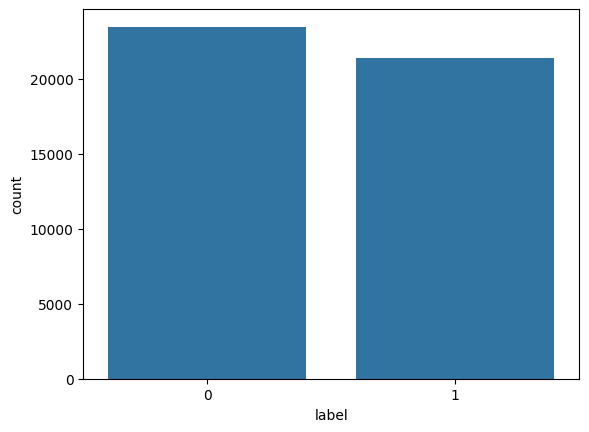

In [7]:
## Class Distribution
sns.countplot(x="label", data=df)
plt.show()

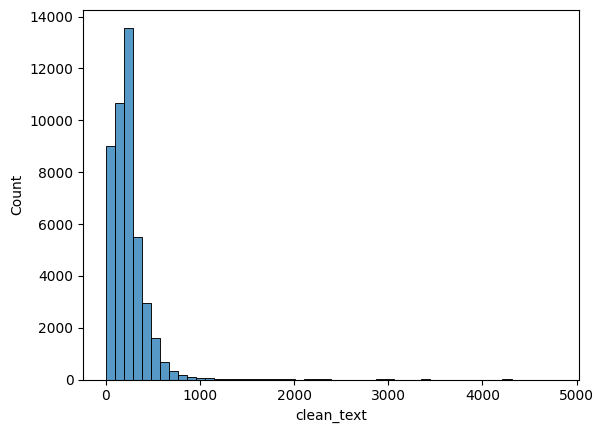

In [8]:
## Text Length Distribution
sns.histplot(text_length, bins=50)
plt.show()

# Feature Extraction (TF-IDF)

In [9]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df["clean_text"])
y = df["label"]

# Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Rule-Based Classifier

In [11]:
fake_keywords = [
    "shocking", "breaking", "exposed", "clickbait",
    "hoax", "conspiracy", "rumor", "unverified"
]

def rule_based_classifier(text):
    for word in fake_keywords:
        if word in text:
            return 0
    return 1

df["rule_pred"] = df["clean_text"].apply(rule_based_classifier)

In [25]:
## Rule-Based Evaluation
rule_accuracy = accuracy_score(df["label"], df["rule_pred"])
rule_precision = precision_score(df["label"], df["rule_pred"])
rule_recall = recall_score(df["label"], df["rule_pred"])
rule_f1 = f1_score(df["label"], df["rule_pred"])

# Machine Learning Models

In [13]:
## Model 1: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

In [14]:
## Model 2: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

In [15]:
## Model 3: Support Vector Machine
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Evaluation Function

In [16]:
def evaluate_model(y_true, y_pred, y_prob=None):
    results = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    if y_prob is not None:
        results["ROC_AUC"] = roc_auc_score(y_true, y_prob)
    return results

nb_results = evaluate_model(y_test, nb_pred, nb_prob)
lr_results = evaluate_model(y_test, lr_pred, lr_prob)
svm_results = evaluate_model(y_test, svm_pred)

In [17]:
## Rule-Based Evaluation
rule_accuracy = accuracy_score(df["label"], df["rule_pred"])
rule_precision = precision_score(df["label"], df["rule_pred"])
rule_recall = recall_score(df["label"], df["rule_pred"])
rule_f1 = f1_score(df["label"], df["rule_pred"])
rule_roc_auc = roc_auc_score(df["label"], df["rule_pred"])

print("Rule-Based Classifier Performance")
print(f"Accuracy  : {rule_accuracy:.4f}")
print(f"Precision : {rule_precision:.4f}")
print(f"Recall    : {rule_recall:.4f}")
print(f"F1-score  : {rule_f1:.4f}")
print(f"ROC-AUC   : {rule_roc_auc:.4f}")
print("-" * 50)

## Naive Bayes Evaluation
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_roc_auc = roc_auc_score(y_test, nb_prob)

print("Naive Bayes Classifier Performance")
print(f"Accuracy  : {nb_accuracy:.4f}")
print(f"Precision : {nb_precision:.4f}")
print(f"Recall    : {nb_recall:.4f}")
print(f"F1-score  : {nb_f1:.4f}")
print(f"ROC-AUC   : {nb_roc_auc:.4f}")
print("-" * 50)

## Logistic Regression Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_prob)

print("Logistic Regression Classifier Performance")
print(f"Accuracy  : {lr_accuracy:.4f}")
print(f"Precision : {lr_precision:.4f}")
print(f"Recall    : {lr_recall:.4f}")
print(f"F1-score  : {lr_f1:.4f}")
print(f"ROC-AUC   : {lr_roc_auc:.4f}")
print("-" * 50)

## Support Vector Machine Evaluation
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

print("Support Vector Machine Classifier Performance")
print(f"Accuracy  : {svm_accuracy:.4f}")
print(f"Precision : {svm_precision:.4f}")
print(f"Recall    : {svm_recall:.4f}")
print(f"F1-score  : {svm_f1:.4f}")
print("-" * 50)

Rule-Based Classifier Performance
Accuracy  : 0.5425
Precision : 0.5109
Recall    : 0.9538
F1-score  : 0.6654
ROC-AUC   : 0.5605
--------------------------------------------------
Naive Bayes Classifier Performance
Accuracy  : 0.9464
Precision : 0.9401
Recall    : 0.9482
F1-score  : 0.9441
ROC-AUC   : 0.9872
--------------------------------------------------
Logistic Regression Classifier Performance
Accuracy  : 0.9894
Precision : 0.9854
Recall    : 0.9925
F1-score  : 0.9890
ROC-AUC   : 0.9995
--------------------------------------------------
Support Vector Machine Classifier Performance
Accuracy  : 0.9960
Precision : 0.9956
Recall    : 0.9960
F1-score  : 0.9958
--------------------------------------------------


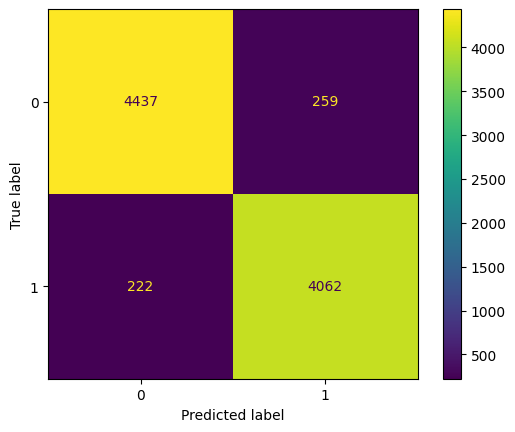

In [18]:
## Confusion Matrices
ConfusionMatrixDisplay.from_predictions(y_test, nb_pred)
plt.show()

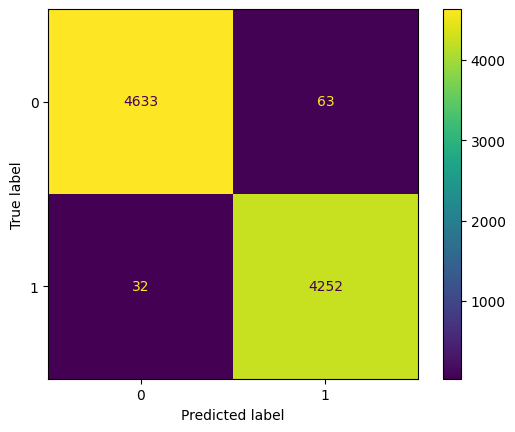

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)
plt.show()

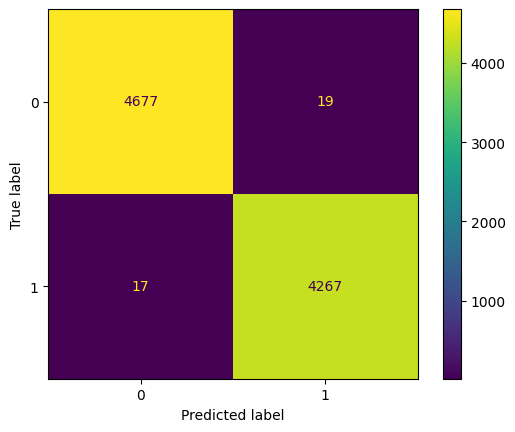

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
plt.show()

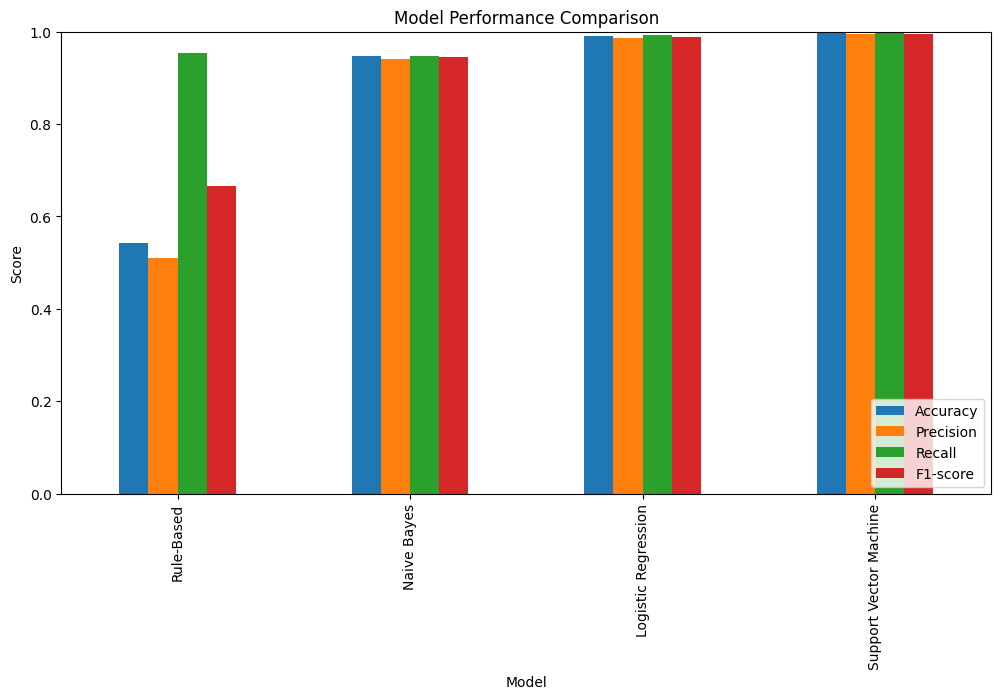

In [21]:
## Create Comparison DataFrame For Models Comparison
comparison_df = pd.DataFrame({
    "Model": [
        "Rule-Based",
        "Naive Bayes",
        "Logistic Regression",
        "Support Vector Machine"
    ],
    "Accuracy": [
        rule_accuracy,
        nb_accuracy,
        lr_accuracy,
        svm_accuracy
    ],
    "Precision": [
        rule_precision,
        nb_precision,
        lr_precision,
        svm_precision
    ],
    "Recall": [
        rule_recall,
        nb_recall,
        lr_recall,
        svm_recall
    ],
    "F1-score": [
        rule_f1,
        nb_f1,
        lr_f1,
        svm_f1
    ],
    "ROC-AUC": [
        rule_roc_auc,
        nb_roc_auc,
        lr_roc_auc,
        None
    ]
})

## Plot Comparison (Accuracy, Precision, Recall, F1)
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

comparison_df.set_index("Model")[metrics].plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()

## Word Clouds

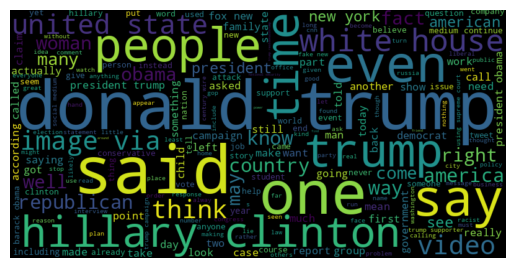

In [22]:
fake_text = " ".join(df[df["label"] == 0]["clean_text"])
real_text = " ".join(df[df["label"] == 1]["clean_text"])

fake_wc = WordCloud(width=800, height=400, background_color="black").generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color="white").generate(real_text)

plt.imshow(fake_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

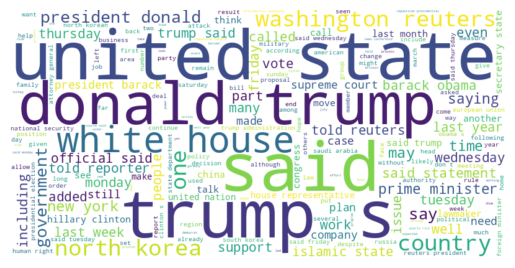

In [23]:
plt.imshow(real_wc, interpolation="bilinear")
plt.axis("off")
plt.show()